<a href="https://colab.research.google.com/github/aszmul/X-ray-Cone-Beam-Computed-Tomography/blob/master/cyclegan_3D_real_data_multitask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
!pip install monai==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 32.3 MB/s 


In [2]:
!nvidia-smi

Thu Oct  6 15:49:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)
 
dump_tensors()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: astor.all_symbols is deprecated.  Please use astor.symbol_data.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: astor.treewalk is deprecated.  Please use astor.tree_walk.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: astor.codegen is deprecated.  Please use astor.code_gen.
/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:182: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: MODES has been renamed to Modes and will be removed in a future version of pywt.



cycleGAN CT-CBCT PHANTOM
==============


Introduction
------------
cycle Generative Adversarial Networks
-------------------------------

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torchvision
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import pickle
from monai.transforms import (
    Compose,
    GaussianSmoothd,
    AddChanneld,
    RandRotated,
    RandFlipd,
    RandBiasFieldd,
    RandGaussianNoised,
    ThresholdIntensityd,
    RandGibbsNoised,
    Resized,
    CenterSpatialCropd,
    ToTensord,
    ScaleIntensityd,
    NormalizeIntensityd,
    AsChannelFirstd
)
from monai.losses import DiceLoss, DiceCELoss

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [3]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/Colab Notebooks/magic_data/explore_dataset_256_128_32_sample/"
cbct_data_path = dataroot + 'cbct/'
ct_data_path = dataroot + 'ct/'

workers = 4 # Number of workers for dataloader
batch_size = 2 # Batch size during training

kernel_size=(7, 7)

n_classes = 4

nc = 1 # Number of channels in the training images.

ngf = 4 # Size of feature maps in generator

ndf = 4 # Size of feature maps in discriminator
num_epochs = 50 # Number of training epochs


lr = 0.00002 # Learning rate for optimizers

beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

Data
----
We will be using data synthetic phantom data with corresponding segmentations

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

# Custom dataload for loading images and labels
class ProstateSegsDataset(Dataset):
    """Phantom CT and segmentations dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
                    -- [ct/cbct_pXXX]            files with images and segmentations as dir in pickle format
                        {'image', 'seg'}
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        temp_list = os.listdir(root_dir)
        # print(temp_list)

        self.files_list = []

        # limit the list of files for trainging to 4000
        for file_name in temp_list:
          self.files_list.append(file_name)


        # print(temp_list)
        self.files_list = temp_list.copy()
        self.root_dir = root_dir
        self.transform = transform
        # print(self.files_list)

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_name = self.files_list[idx]
        # load as numpy and scale intensity 0-1

        data_file = open(self.root_dir + sample_name, 'rb')
        data = pickle.load(data_file)
        data_file.close()
        image = data['image']
        seg = data['seg']

        # image = np.asarray(Image.open(self.root_dir  + 'real/' + img_name))/255

        # seg_name = self.image_list[idx].split('.jpg')[0] + '_comb.npy'
        # seg = np.load(self.root_dir + 'labels_combined/' + seg_name)

        sample = {'image': image, 'seg': seg}

        if self.transform:
            sample = self.transform(sample)

        return sample


CBCT_transforms=Compose([
                               AddChanneld(keys=['image', 'seg']),
                              #  GaussianSmoothd(keys=['image'], sigma= 2.0),
                              #  Resized(keys=['image'], spatial_size = (first_image_size, first_image_size), mode="nearest"),
                              #  Resized(keys=['image', 'seg'], spatial_size = (image_size, image_size), mode=("bilinear", "nearest")),
                              #  CenterSpatialCropd(keys=['image', 'seg'], roi_size = (image_size, image_size)),
                              #  RandFlipd(keys=['image', 'seg'], prob=0.5, spatial_axis=1),
                              #  RandRotated(keys=['image', 'seg'], range_x=[-0.6, 0.6], prob=1, mode=['bilinear', 'nearest'], padding_mode='zeros'),
                              #  RandBiasFieldd(keys=['image'], degree=3, coeff_range=(0.0, 0.3), prob=0.1), 
                              #  RandGibbsNoised(keys=['image'], prob=1.0, alpha=(0.5, 0.9)),
                              #  RandGaussianNoised(keys=['image'], prob=1.0, mean=0.0, std=0.1),
                              #  ThresholdIntensityd(keys=['image'], threshold=1.0, above=False, cval=1.0),
                              #  ThresholdIntensityd(keys=['image'], threshold=0.0, above=True, cval=0.0),
                               ToTensord(keys=['image', 'seg']),
                               NormalizeIntensityd(keys=['image'], subtrahend = 0.5, divisor = 0.5),
                           ])


CT_transforms=Compose([
                               AddChanneld(keys=['image', 'seg']),
                              #  Resized(keys=['image', 'seg'], spatial_size = (image_size, image_size), mode=("bilinear", "nearest")),
                              #  CenterSpatialCropd(keys=['image', 'seg'], roi_size = (image_size, image_size)),
                              #  RandFlipd(keys=['image', 'seg'], prob=0.5, spatial_axis=1),
                              #  RandRotated(keys=['image', 'seg'], range_x=[-0.6, 0.6], prob=1, mode=['bilinear', 'nearest'], padding_mode='zeros'),
                              #  ThresholdIntensityd(keys=['image'], threshold=1.0, above=False, cval=1.0),
                              #  ThresholdIntensityd(keys=['image'], threshold=0.0, above=True, cval=0.0),
                               ToTensord(keys=['image', 'seg']),
                               NormalizeIntensityd(keys=['image'], subtrahend = 0.5, divisor = 0.5),
                           ])


CBCT_dataset = ProstateSegsDataset(root_dir=cbct_data_path, transform=CBCT_transforms)

CT_dataset = ProstateSegsDataset(root_dir=ct_data_path, transform=CT_transforms)


# Create the dataloader
CBCT_dataloader = torch.utils.data.DataLoader(CBCT_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

CT_dataloader = torch.utils.data.DataLoader(CT_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



/usr/local/lib/python3.7/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(2, 1, 256, 128, 32)


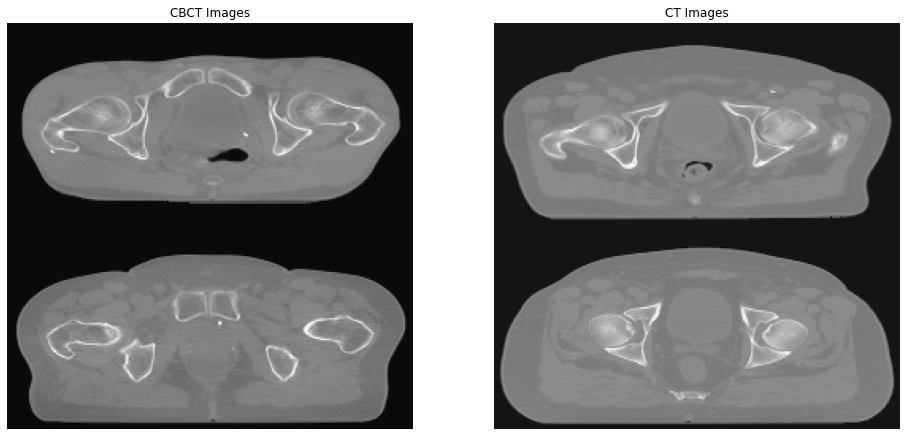

In [5]:
# Plot some training images
CBCT_batch = next(iter(CBCT_dataloader))
CT_batch = next(iter(CT_dataloader))
plt.figure(figsize=(16,16))


print(CBCT_batch['image'].shape)

plt.subplot(1,2,1)
plt.axis("off")
plt.title("CBCT Images")
plt.imshow(np.flipud(np.transpose(vutils.make_grid(CBCT_batch['image'][:,:,:,:, 16].to(device)[:32], padding=0, normalize=True).cpu(),(2,1,0))))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("CT Images")
plt.imshow(np.flipud(np.transpose(vutils.make_grid(CT_batch['image'][:,:,:,:,16].to(device)[:32], padding=0, normalize=True).cpu(),(2,1,0))))

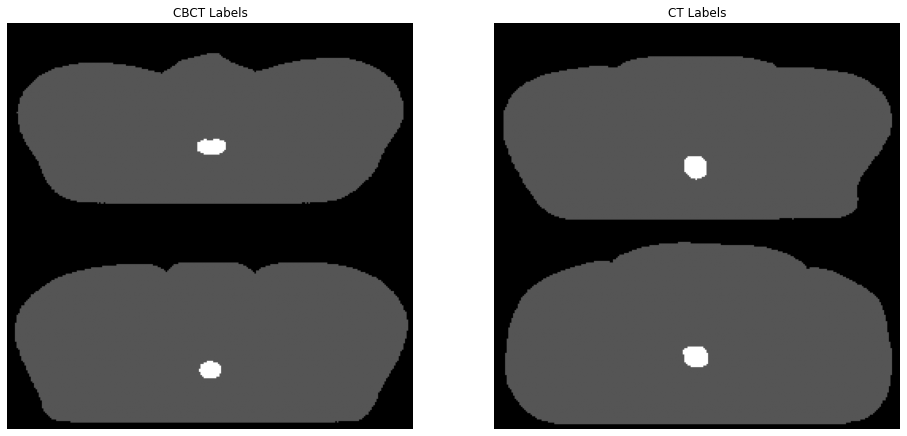

In [6]:
# Plot some training images
# CBCT_batch = next(iter(CBCT_dataloader))
# CT_batch = next(iter(CT_dataloader))
plt.figure(figsize=(16,16))


plt.subplot(1,2,1)
plt.axis("off")
plt.title("CBCT Labels")
plt.imshow(np.flipud(np.transpose(vutils.make_grid(CBCT_batch['seg'][:,:,:,:,4].to(device)[:32], padding=0, normalize=True).cpu(),(2,1,0))))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("CT Labels")
plt.imshow(np.flipud(np.transpose(vutils.make_grid(CT_batch['seg'][:,:,:,:,4].to(device)[:32], padding=0, normalize=True).cpu(),(2,1,0))))

In [7]:
CBCT_batch = next(iter(CBCT_dataloader))

CBCT_batch['image'].size()

(2, 1, 256, 128, 32)

In [8]:
CBCT_batch['image'].min()

tensor(-1.2754)
Metadata
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
	space: RAS

Applied operations
[]
Is batch?: False

Implementation
--------------

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.

Weight Initialization
~~~~~~~~~~~~~~~~~~~~~

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.




In [9]:
# custom weights initialization called on netG and netD
# not included yet
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv3d):
        # nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.kaiming_uniform_(m.weight.data, a=0, mode='fan_in', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        # nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.kaiming_uniform_(m.weight.data, a=0, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(m.bias.data, 0)

Generator
~~~~~~~~~



In [10]:
# Generator Code
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv3d(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv3d(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv3d(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv3d(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[4] - x1.size()[4]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv3d_img(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv3d_img, self).__init__()
        self.conv = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=1),
                                  nn.Tanh())

    def forward(self, x):
        return self.conv(x)        


class OutConv3d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv3d, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)   


class Encoder(nn.Module):
  def __init__(self, n_channels=1, n_filters=4, bilinear=False):
      super(Encoder, self).__init__()
      self.n_channels = n_channels
      self.bilinear = bilinear

      self.inc = DoubleConv3d(self.n_channels, n_filters)
      self.down1 = Down(n_filters, n_filters*2)
      self.down2 = Down(n_filters*2, n_filters*4)
      self.down3 = Down(n_filters*4, n_filters*8)


  def forward(self, x):
      x1 = self.inc(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      return x1, x2, x3, x4

class Decoder(nn.Module):
  def __init__(self, n_classes, n_filters=4, bilinear=False):
      super(Decoder, self).__init__()
      self.n_classes = n_classes
      self.bilinear = bilinear

      factor = 2 if bilinear else 1
      self.up1 = Up(n_filters*8, n_filters*4 // factor, bilinear)
      self.up2 = Up(n_filters*4, n_filters*2 // factor, bilinear)
      self.up3 = Up(n_filters*2, n_filters, bilinear)
      self.outc = OutConv3d_img(n_filters, n_classes)

  def forward(self, x1, x2, x3, x4):
      x = self.up1(x4, x3)
      x = self.up2(x, x2)
      x = self.up3(x, x1)
      refined = self.outc(x)
      return refined


Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [11]:
# Create the generator for synCT images and segmentations
net_CT_G_E = Encoder(n_channels=1, n_filters=ngf).to(device)
net_CT_G_D_img = Decoder(n_classes=1, n_filters=ngf).to(device)


# Create the generator for synCBCT images only
net_CBCT_G_E = Encoder(n_channels=1, n_filters=ngf).to(device)
net_CBCT_G_D_img = Decoder(n_classes=1, n_filters=ngf).to(device)
net_CBCT_G_D_seg = Decoder(n_classes=4, n_filters=ngf).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    net_CT_G_E = nn.DataParallel(net_CT_G_E, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CT_G_D_img = nn.DataParallel(net_CT_G_D_img, list(range(ngpu)))  

if (device.type == 'cuda') and (ngpu > 1):
    net_CBCT_G_E = nn.DataParallel(net_CBCT_G_E, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CBCT_G_D_img = nn.DataParallel(net_CBCT_G_D_img, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CBCT_G_D_seg = nn.DataParallel(net_CBCT_G_D_seg, list(range(ngpu)))  


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
net_CT_G_E.apply(weights_init)
net_CT_G_D_img.apply(weights_init)

net_CBCT_G_E.apply(weights_init)
net_CBCT_G_D_img.apply(weights_init)

net_CBCT_G_D_seg.apply(weights_init)

# Print the model
# print(netG_E)
# print(netG_D_img)
# print(netG_D_seg)

Decoder(
  (up1): Up(
    (up): ConvTranspose3d(32, 16, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (conv): DoubleConv3d(
      (double_conv): Sequential(
        (0): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (5): ReLU(inplace=True)
      )
    )
  )
  (up2): Up(
    (up): ConvTranspose3d(16, 8, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (conv): DoubleConv3d(
      (double_conv): Sequential(
        (0): Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplac

Discriminator
~~~~~~~~~~~~~



Discriminator Code



In [12]:
class Discriminator3d(nn.Module):
    def __init__(self, ngpu, num_channels):
        super(Discriminator3d, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128 x 64
            nn.Conv3d(num_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input is (nc) x 64 x 64 x 32
            nn.Conv3d(ndf, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32 x 16
            nn.Conv3d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16 x 8
            nn.Conv3d(ndf * 2, ndf * 4, (4,4,2), 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 4) x 8 x 8 x 4
            nn.Conv3d(ndf * 4, ndf * 8, (4,4,2), 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 4) x 4 x 4 x 2
            nn.Conv3d(ndf * 8, ndf * 8, (4,4,2), 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 2 x 2 x 1
            nn.Conv3d(ndf * 8, 1, (4,2,2), 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# input = torch.randn(1, 256, 128, 32)
# print(input.shape)

# conv1 = nn.Conv3d(1, ndf, 4, 2 , 1, bias=False)
# temp1 = conv1(input)
# print(temp1.shape)

# conv2 = nn.Conv3d(ndf, ndf, 4, 2, 1, bias=False)
# temp2 = conv2(temp1)
# print(temp2.shape)

# conv3 = nn.Conv3d(ndf, ndf * 2, 4, 2, 1, bias=False)
# temp3 = conv3(temp2)
# print(temp3.shape)

# conv4 = nn.Conv3d(ndf * 2, ndf * 4, (4,4,2), 2, 1, bias=False)
# temp4 = conv4(temp3)
# print(temp4.shape)

# conv5 = nn.Conv3d(ndf * 4, ndf * 4, (4,4,2) , 2, 1, bias=False)
# temp5 = conv5(temp4)
# print(temp5.shape)

# # sigm5 = nn.Sigmoid()
# # temp5s = sigm5(temp5)
# # print(temp5s.shape)

# conv6 = nn.Conv3d(ndf * 4, ndf * 4, (4,4,2) , 2, 1, bias=False)
# temp6 = conv6(temp5)
# print(temp6.shape)

# conv7 = nn.Conv3d(ndf * 4, 1, (4,2,2) , 2, 0, bias=False)
# temp7 = conv7(temp6)
# print(temp7.shape)



Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [13]:
# Create the Discriminator for synCT images 
net_CT_D_img = Discriminator3d(ngpu, nc).to(device)

# Create the Discriminator for synCBCT images 
net_CBCT_D_img = Discriminator3d(ngpu, nc).to(device)

# Create the Discriminator for synCT segmentations
net_CBCT_D_seg = Discriminator3d(ngpu, n_classes).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    net_CT_D_img = nn.DataParallel(net_CT_D_img, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CBCT_D_img = nn.DataParallel(net_CBCT_D_img, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CBCT_D_seg = nn.DataParallel(net_CBCT_D_seg, list(range(ngpu)))    
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# net_CT_D_img.apply(weights_init)
# net_CBCT_D_img.apply(weights_init)
# net_CBCT_D_seg.apply(weights_init)


# Print the model
print(net_CBCT_D_seg)

Discriminator3d(
  (main): Sequential(
    (0): Conv3d(4, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv3d(4, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (5): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv3d(8, 16, kernel_size=(4, 4, 2), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (8): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv3d(16, 32, kernel_size=(4, 4, 2), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (11): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12)

In [14]:
# Print the model
print(net_CBCT_G_D_img)

Decoder(
  (up1): Up(
    (up): ConvTranspose3d(32, 16, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (conv): DoubleConv3d(
      (double_conv): Sequential(
        (0): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (5): ReLU(inplace=True)
      )
    )
  )
  (up2): Up(
    (up): ConvTranspose3d(16, 8, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (conv): DoubleConv3d(
      (double_conv): Sequential(
        (0): Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplac

Loss Functions and Optimizers
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [15]:
# Initialize BCELoss function
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

# Initialize L1_Loss function for cycle
criterion_cycle = nn.L1Loss()

# Initialize L1_Loss function for identity (CBCT_G(CBCT) should give back CBCT image)
criterion_idt = nn.L1Loss()

# criterion_degraded = nn.MSELoss()
criterion_seg = DiceCELoss(include_background=True, to_onehot_y=False, softmax=True, lambda_dice=0.5, lambda_ce=0.5)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D for CT arm
# optimizer_CT_D_img = optim.Adam(net_CT_D_img.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_CT_G_E = optim.Adam(net_CT_G_E.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_CT_G_D_img = optim.Adam(net_CT_G_D_img.parameters(), lr=lr, betas=(beta1, 0.999))

# Setup a joint Adam optimizers for all CT and CBCT Discrimiantors
params_D = list(net_CT_D_img.parameters()) + list(net_CBCT_D_img.parameters()) + list(net_CBCT_D_seg.parameters())
optimizer_D = optim.Adam(params_D, lr=lr, betas=(beta1, 0.999))

# Setup Adam optimizers for both G and D for CBCT arm
# optimizer_CBCT_D_img = optim.Adam(net_CBCT_D_img.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_CBCT_D_seg = optim.Adam(net_CBCT_D_seg.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_CBCT_G_E = optim.Adam(net_CBCT_G_E.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_CBCT_G_D_img = optim.Adam(net_CBCT_G_D_img.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_CBCT_G_D_seg = optim.Adam(net_CBCT_G_D_seg.parameters(), lr=lr, betas=(beta1, 0.999))

# Setup a joint Adam optimizers for all CT and CBCT Generators
params_G = list(net_CT_G_E.parameters()) + list(net_CT_G_D_img.parameters()) + list(net_CBCT_G_E.parameters()) + list(net_CBCT_G_D_img.parameters()) + list(net_CBCT_G_D_seg.parameters())
optimizer_G = optim.Adam(params_G, lr=lr, betas=(beta1, 0.999))



Training
~~~~~~~~

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in `ganhacks <https://github.com/soumith/ganhacks>`__.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.




In [24]:
# Training Loop

# Lists to keep track of progress
before_CT_list = []
after_CT_list = []
before_CBCT_list = []
after_CBCT_list = []
seg_list = []
seg_ref_list = []
G_CT_losses = []
G_CBCT_losses = []
G_CBCT_seg_losses = []
D_CBCT_img_losses = []
D_CBCT_seg_losses = []
D_CT_img_losses = []
iters = 0

scaler = torch.cuda.amp.GradScaler()

print("Starting Training Loop...")
# For each epoch

num_epochs = 100

data_type = torch.float16

for epoch in range(num_epochs):
    # For each batch in the dataloader
    # for i, data in enumerate(dataloader, 0):
    i = 0
    # for degraded_item, reference_item in zip(degraded_dataloader, reference_dataloader):

    #     degraded_batch, degraded_labels = degraded_item
    #     reference_batch, reference_labels = reference_item
    for i, (CBCT_batch, CT_batch) in enumerate(zip(CBCT_dataloader, CT_dataloader)):
        

        ############################
        # (1) Update D networks: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        net_CT_D_img.zero_grad()
        net_CBCT_D_img.zero_grad()
        net_CBCT_D_seg.zero_grad()

        # print(CT_batch['image'].size())
        # print(CT_batch['seg'].size())
        # print(CBCT_batch['image'].size())

        sig = nn.Sigmoid()

        with torch.autocast(device_type='cuda', dtype=data_type):

          # Format batch
          real_CT_img = CT_batch['image'].to(device)
          # seg is a single channel image, channel is collapsed, converted to int, then one hot vector is crested and permuted as it gives (batches, x_size, y_size, channels)
          real_CT_one_hot = nn.functional.one_hot(CT_batch['seg'].to(device).squeeze(dim=1).to(torch.int64), n_classes)
          # print(real_CT_one_hot.size())
          real_CT_seg = real_CT_one_hot.permute(0, 4, 1, 2, 3)

          real_CBCT_img = CBCT_batch['image'].to(device)

          # Create labels of for real batches
          b_size = real_CT_img.size(0)
          real_CT_img_label = torch.full((b_size,), real_label, dtype=data_type, device=device)
          real_CT_seg_label = torch.full((b_size,), real_label, dtype=data_type, device=device)
          real_CBCT_img_label = torch.full((b_size,), real_label, dtype=data_type, device=device)


          ## Forward pass with real CT/CBCT batches through Discriminators

          # Calculate loss on all-real batches

          # Discriminator on the CT side is expecting a CBCT as output
          output_CT_D_img_real_CBCT_img = net_CT_D_img(real_CBCT_img).view(-1)
          # print(net_CT_D_img(real_CBCT_img).size())
          # print(real_CBCT_img_label.size())
          loss_CT_D_img_real_CBCT = criterion(sig(output_CT_D_img_real_CBCT_img), real_CBCT_img_label) # takes real CBCT image in and real label (ones x bachsize) 

          # Discriminator on the CBCT side is expecting a CT as output
          output_CBCT_D_img_real_CT_img = net_CBCT_D_img(real_CT_img).view(-1)
          loss_CBCT_D_img_real_CT = criterion(sig(output_CBCT_D_img_real_CT_img), real_CT_img_label) # takes real CT image in and real labels (ones x bachsize) 


          # print(real_CT_seg.size())
          # print(real_CT_seg.size())
          output_CBCT_D_seg_real_CT_seg = net_CBCT_D_seg(real_CT_seg.to(data_type)).view(-1)
          loss_CBCT_D_seg_real_CT = criterion(output_CBCT_D_seg_real_CT_seg, real_CT_seg_label).to(data_type) # takes real CT segmentations in and real labels (ones x bachsize)


          ## Forward pass with fake CT/CBCT batches through Discriminators
          # There is no grad_zero for generators when discriminators are trained/updated

          # Generate fake image and segmentation batches with Generators
          CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4 = net_CBCT_G_E(CBCT_batch['image'].to(device))
          fake_CT_img = net_CBCT_G_D_img(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4) + CBCT_batch['image'].to(device)
          fake_CT_seg = net_CBCT_G_D_seg(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4).double()

          # temp=net_CBCT_G_D_img(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4).detach().cpu()
          # print(temp.min())
          # print(temp.max())


          CT_x1, CT_x2, CT_x3, CT_x4 = net_CT_G_E(CT_batch['image'].to(device))
          fake_CBCT_img = net_CT_G_D_img(CT_x1, CT_x2, CT_x3, CT_x4) + CT_batch['image'].to(device)
          

          # Classify all fake batch with D

          # Create labels of for fake batches
          fake_CT_img_label = torch.full((b_size,), fake_label, dtype=data_type, device=device)
          fake_CT_seg_label = torch.full((b_size,), fake_label, dtype=data_type, device=device)
          fake_CBCT_img_label = torch.full((b_size,), fake_label, dtype=data_type, device=device)


          # Calculate D's loss on the all-fake batch
          # Discriminator on the CT side is expecting a CBCT as output
          output_CT_D_img_fake_CBCT_img = net_CT_D_img(fake_CBCT_img.detach()).view(-1) # not sure if detach should be here
          loss_CT_D_img_fake_CBCT = criterion(output_CT_D_img_fake_CBCT_img, fake_CBCT_img_label) # takes fake CBCT image in and fake label (zeros x bachsize) 

          # Discriminator on the CBCT side is expecting a CT as output
          output_CBCT_D_img_fake_CT_img = net_CBCT_D_img(real_CT_img.detach()).view(-1) # not sure if detach should be here
          loss_CBCT_D_img_fake_CT = criterion(output_CBCT_D_img_fake_CT_img, fake_CT_img_label) # takes fake CBCT image in and fake labels (zeros x bachsize) 

          output_CBCT_D_seg_fake_CT_seg = net_CBCT_D_seg(fake_CT_seg.detach().to(data_type)).view(-1) # not sure if detach should be here
          loss_CBCT_D_seg_fake_CT = criterion(output_CBCT_D_seg_fake_CT_seg, fake_CT_seg_label).to(data_type) # takes fake CBCT segmentations in and fake labels (zeros x bachsize)


          
          # Compute mean loss of Discriminators as sum over the fake and the real batches
          loss_CT_D_img = loss_CT_D_img_real_CBCT + loss_CT_D_img_fake_CBCT 
          loss_CBCT_D_img = loss_CBCT_D_img_real_CT + loss_CBCT_D_img_fake_CT
          loss_CBCT_D_seg = loss_CBCT_D_seg_real_CT + loss_CBCT_D_seg_fake_CT


          err_CT_D_img = loss_CT_D_img.mean().item()
          err_CBCT_D_img = loss_CBCT_D_img.mean().item()
          err_CBCT_D_seg = loss_CBCT_D_seg.mean().item()


          # Calculate the D gradients for this batch
          scaler.scale(loss_CT_D_img_fake_CBCT).backward()
          scaler.scale(loss_CBCT_D_img_fake_CT).backward()
          scaler.scale(loss_CBCT_D_seg_fake_CT).backward()


          # Update Discriminators
          scaler.step(optimizer_D)


          ############################
          # (2) Update G network: maximize log(D(G(z)))
          ###########################
          net_CT_G_E.zero_grad()
          net_CT_G_D_img.zero_grad()

          net_CBCT_G_E.zero_grad()
          net_CBCT_G_D_img.zero_grad()
          net_CBCT_G_D_seg.zero_grad()


          ### cycle reconstructions 
          ## get fake CTs from fake CBCTs , and segmentations
          CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4 = net_CBCT_G_E(fake_CBCT_img.detach())
          rec_CT_img = net_CBCT_G_D_img(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4) + fake_CBCT_img
          rec_CT_seg = net_CBCT_G_D_seg(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4).double()
          

          ## get fake CBCTs from fake CTs 
          CT_x1, CT_x2, CT_x3, CT_x4 = net_CT_G_E(fake_CT_img.detach())
          rec_CBCT_img = net_CT_G_D_img(CT_x1, CT_x2, CT_x3, CT_x4) + fake_CT_img

          loss_CT_cycle = criterion_cycle(rec_CT_img, real_CT_img)
          loss_CBCT_cycle = criterion_cycle(rec_CBCT_img, real_CBCT_img)

          # fake labels are real for generator cost
          fake_CT_img_label.fill_(real_label)  
          fake_CT_seg_label.fill_(real_label)  
          fake_CBCT_img_label.fill_(real_label)  

          # Since we just updated Discriminators, perform another forward pass of all-fake batch through D
          output_CT_D_img_fake_CBCT_img = net_CT_D_img(fake_CBCT_img).view(-1)
          output_CBCT_D_img_fake_CT_img = net_CBCT_D_img(fake_CT_img).view(-1)
          output_CBCT_D_img_fake_CT_seg = net_CBCT_D_seg(fake_CT_seg.to(torch.float32)).view(-1).to(data_type)

          
          ## # identity reconstructions
          # get CT and generates synCT which should be the same as input)
          CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4 = net_CBCT_G_E(real_CT_img)
          idt_CT_img = net_CBCT_G_D_img(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4) + real_CT_img
          # idt_CT_seg = net_CBCT_G_D_seg(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4).double()

          # get CBCT and generates synCBCT which should be the same as input
          CT_x1, CT_x2, CT_x3, CT_x4 = net_CT_G_E(real_CBCT_img)
          idt_CBCT_img = net_CT_G_D_img(CT_x1, CT_x2, CT_x3, CT_x4) + real_CBCT_img

          loss_CBCT_idt = criterion_idt(idt_CT_img, real_CT_img)
          loss_CT_idt = criterion_idt(idt_CBCT_img, real_CBCT_img)
          #####

          # Calculate G's loss based on this output
          # Fake images from G are given real label to force G to produce better images
          loss_CT_G = criterion(output_CT_D_img_fake_CBCT_img, fake_CT_img_label)
          loss_CBCT_G = criterion(output_CBCT_D_img_fake_CT_img, fake_CBCT_img_label)
          # loss_CBCT_G = criterion(output_CBCT_D_img_fake_CT_img, fake_CBCT_img_label)


          # print(rec_CT_seg.size())
          # print(real_CT_seg.size())
          loss_CBCT_G_seg = criterion_seg(rec_CT_seg, real_CT_seg)
          # print(loss_CBCT_G_seg.item())
          # Calculate gradients for G

          loss_total_CT_G = loss_CT_G + loss_CT_idt + loss_CT_cycle
          
          # loss_total_CT_G.backward(retain_graph=True)
          scaler.scale(loss_total_CT_G).backward(retain_graph=True)
          

          loss_total_CBCT_G = loss_CBCT_G + loss_CBCT_idt + loss_CBCT_cycle + loss_CBCT_G_seg

          
          # loss_total_CBCT_G.backward()
          scaler.scale(loss_total_CBCT_G).backward()

          err_total_CT_G = loss_total_CT_G.mean().item()
          err_total_CBCT_G = loss_total_CBCT_G.mean().item()
          err_CBCT_G_seg = loss_CBCT_G_seg.mean().item()

          # Update Generators
          scaler.step(optimizer_G)

          scaler.update()
        

        # Output training stats
        # if i % 50 == 0:
        #     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #           % (epoch, num_epochs, i, len(degraded_dataloader),
        #              errD.item(), errG.item(), D_x, err_total_CT_G, err_total_CBCT_G))
            
        if i % 4 == 0:
            print('[%d/%d][%d/%d]'
                  % (epoch, num_epochs, i, len(CT_dataloader)))
        
        # # Save Losses for plotting later
        G_CBCT_losses.append(err_total_CBCT_G)
        G_CT_losses.append(err_total_CT_G)
        G_CBCT_seg_losses.append(err_CBCT_G_seg)

        D_CBCT_img_losses.append(err_CBCT_D_img)
        D_CBCT_seg_losses.append(err_CBCT_D_img)
        D_CT_img_losses.append(err_CT_D_img)
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 200 == 0) or ((epoch == num_epochs-1) and (i == len(CT_dataloader)-1)):
            with torch.no_grad():
                CT_x1, CT_x2, CT_x3, CT_x4 = net_CT_G_E(CT_batch['image'].to(device))
                fake_CBCT_img = (net_CT_G_D_img(CT_x1, CT_x2, CT_x3, CT_x4) + CT_batch['image'].to(device)).detach().cpu()

                CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4 = net_CBCT_G_E(CBCT_batch['image'].to(device))
                fake_CT_img = (net_CBCT_G_D_img(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4) + CBCT_batch['image'].to(device)).detach().cpu()
                fake_CT_seg = torch.argmax(net_CBCT_G_D_seg(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4), dim=1, keepdim=True).detach().cpu()


                # print('fake_img', fake_img.size())
                # print('fake_seg_before', (netG_D_seg(x1, x2, x3, x4).detach().cpu()).size())
                # print('fake_seg', fake_seg.size())

                # plt.hist(degraded_batch['seg'].numpy().flatten(), 20)
                # plt.show()

                # plt.hist(fake_seg.numpy().flatten(), 20)
                # plt.show()



            before_CT_list.append(vutils.make_grid(CT_batch['image'][:,:,:,:, 8], padding=1, normalize=True))    
            after_CT_list.append(vutils.make_grid(fake_CT_img[:,:,:,:, 8], padding=1, normalize=True))

            before_CBCT_list.append(vutils.make_grid(CBCT_batch['image'][:,:,:,:, 8], padding=1, normalize=True))    
            after_CBCT_list.append(vutils.make_grid(fake_CT_img[:,:,:,:, 8], padding=1, normalize=True))

            seg_ref_list.append(vutils.make_grid(CBCT_batch['seg'][:,:,:,:, 8], padding=1, normalize=False))    
            seg_list.append(vutils.make_grid(fake_CT_seg[:,:,:,:, 8], padding=1, normalize=False))
            
        iters += 1
        i += 1


Starting Training Loop...
[0/100][0/4]
[1/100][0/4]


Exception ignored in: <function _after_fork at 0x7f80613f97a0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 1375, in _after_fork
    thread._reset_internal_locks(False)
  File "/usr/lib/python3.7/threading.py", line 811, in _reset_internal_locks
    self._started._reset_internal_locks()
  File "/usr/lib/python3.7/threading.py", line 505, in _reset_internal_locks
    self._cond.__init__(Lock())
  File "/usr/lib/python3.7/threading.py", line 238, in __init__
    self._waiters = _deque()
KeyboardInterrupt: 


KeyboardInterrupt: ignored

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




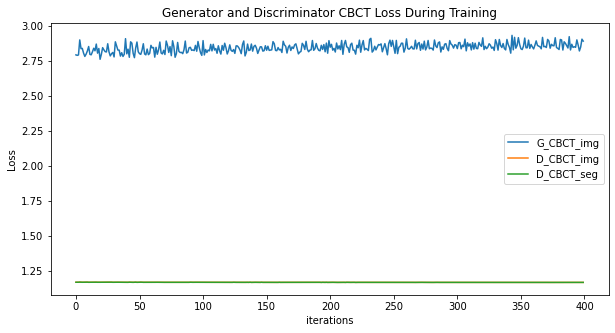

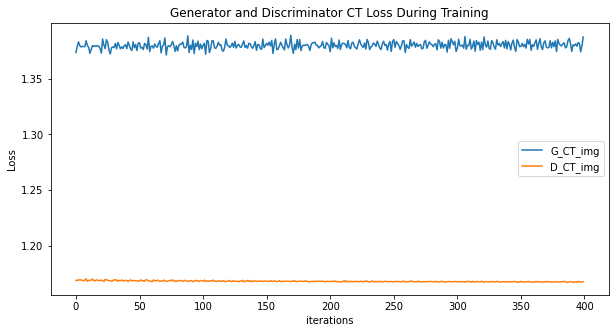

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator CBCT Loss During Training")
plt.plot(G_CBCT_losses,label="G_CBCT_img")
plt.plot(D_CBCT_img_losses,label="D_CBCT_img")
plt.plot(D_CBCT_seg_losses,label="D_CBCT_seg")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator CT Loss During Training")
plt.plot(G_CT_losses,label="G_CT_img")
plt.plot(D_CT_img_losses,label="D_CT_img")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [ ]:
# #%%capture
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(i, animated=True)] for i in seg_list]
# # ims = [[plt.imshow(np.transpose(i,(1,2,0))[:,:,0], animated=True)] for i in seg_ref_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

In [22]:
CBCT_batch = next(iter(CBCT_dataloader))
CT_batch = next(iter(CT_dataloader))

CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4 = net_CBCT_G_E(CBCT_batch['image'].to(device))
fake_CT_img = (net_CBCT_G_D_img(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4) + CBCT_batch['image'].to(device)).detach().cpu()
fake_CT_seg = torch.argmax(net_CBCT_G_D_seg(CBCT_x1, CBCT_x2, CBCT_x3, CBCT_x4), dim=1, keepdim=True).detach().cpu()

real_CBCT_seg = CBCT_batch['seg']
proc_CBCT_seg = torch.argmax(nn.functional.one_hot(CBCT_batch['seg'].to(device).squeeze(dim=1).to(torch.int64), n_classes).permute(0, 4, 1, 2, 3), dim=1, keepdim=True).detach().cpu()


CT_x1, CT_x2, CT_x3, CT_x4 = net_CT_G_E(CT_batch['image'].to(device))
fake_CBCT_img = (net_CT_G_D_img(CT_x1, CT_x2, CT_x3, CT_x4) + CT_batch['image'].to(device)).detach().cpu()


real_CBCT_seg = CBCT_batch['seg']
proc_CBCT_seg = torch.argmax(nn.functional.one_hot(CBCT_batch['seg'].to(device).squeeze(dim=1).to(torch.int64), n_classes).permute(0, 4, 1, 2, 3), dim=1, keepdim=True).detach().cpu()


# a = np.asarray(seg_ref_list[-1])

# print(a.size)

print(fake_CT_img.min())
print(fake_CT_img.max())

tensor(-2.1320)
tensor(2.2139)


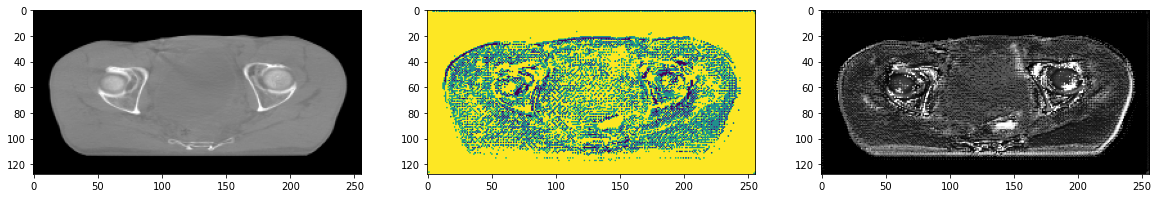

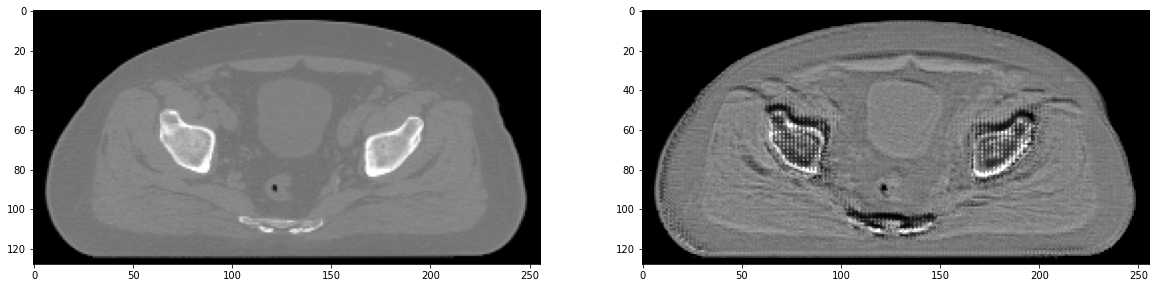

In [23]:
fake_CT_seg[0].size()

n=0
slice = 24

org = np.asarray(CT_batch['image'][n][:,:,:, slice])
fake = np.asarray(fake_CT_img[n][:,:,:, slice])

# plt.hist(org.flatten(),100)
# plt.show()
# plt.hist(fake.flatten(),100)
# plt.show()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(np.rot90(CBCT_batch['image'][n][:,:,:, slice].squeeze()), vmin=-1, vmax=1, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(np.rot90(fake_CT_seg[n][:,:,:, slice].squeeze()))

plt.subplot(1,3,3)
plt.imshow(np.rot90(fake_CT_img[n][:,:,:, slice].squeeze()), vmin=-1, vmax=1, cmap='gray')
plt.show()


plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(np.rot90(CT_batch['image'][n][:,:,:, slice].squeeze()), vmin=-1, vmax=1, cmap='gray')


plt.subplot(1,2,2)
plt.imshow(np.rot90(fake_CBCT_img[n][:,:,:, slice].squeeze()), vmin=-1, vmax=1, cmap='gray')
plt.show()


**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




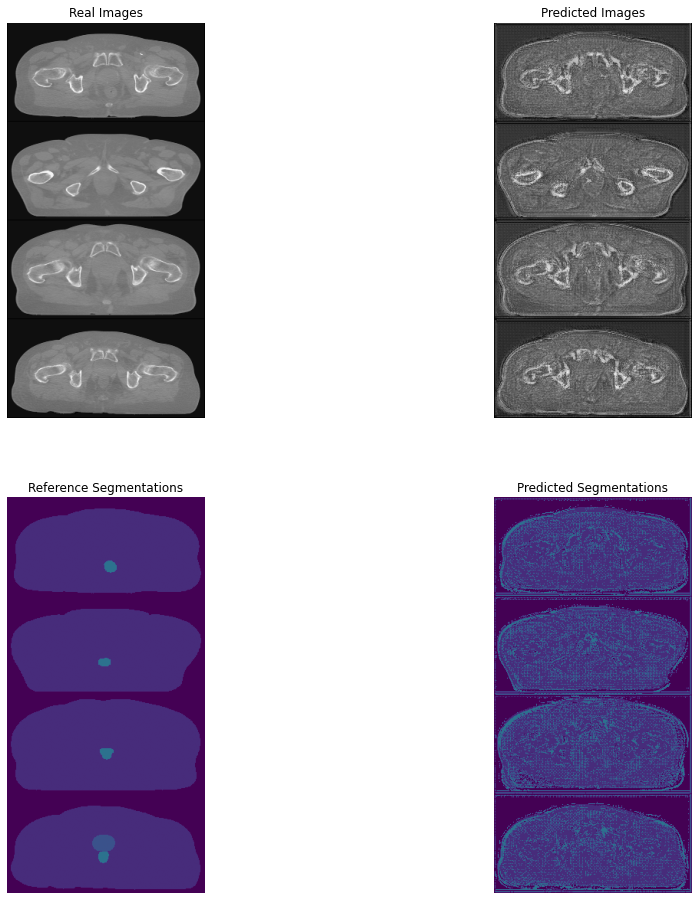

In [37]:
# Grab a batch of real images from the dataloader
CBCT_batch = next(iter(CBCT_dataloader))

# Plot the real images
plt.figure(figsize=(16,16))


plt.subplot(2,2,1)
plt.axis("off")
plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# plt.title("Degraded Images")
plt.imshow(np.rot90(np.transpose(before_CBCT_list[-1],(1,2,0))))

# print(before_list[0])

# Plot the degraded images from the last epoch
plt.subplot(2,2,2)
plt.axis("off")
# plt.title("Degraded Images")
plt.imshow(np.rot90(np.transpose(after_CBCT_list[-1],(1,2,0))))
plt.title("Predicted Images")


# Plot the refined images from the last epoch
plt.subplot(2,2,3)
plt.axis("off")
plt.title("Reference Segmentations")
# plt.imshow(np.transpose(after_list[-2],(1,2,0)))
plt.imshow(np.rot90(np.transpose(seg_ref_list[-1],(1,2,0))[:,:,0]), vmin=0, vmax=8)

# print(after_list[0])

plt.subplot(2,2,4)
plt.axis("off")
# plt.title("Degraded Images")
# plt.imshow(np.transpose(before_list[-1],(1,2,0)))
plt.title("Predicted Segmentations")
plt.imshow(np.rot90(np.transpose(seg_list[-1],(1,2,0)).astype(float)[:,:,0]), vmin=0, vmax=8)
plt.show()

# print(seg_ref_list[0])
# print(seg_list[0])


tensor(1.)
Metadata
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)

Applied operations
[]
Is batch?: False
(132, 1042, 3)
float64
float64


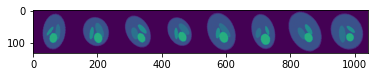

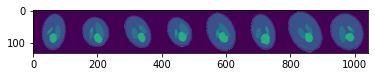

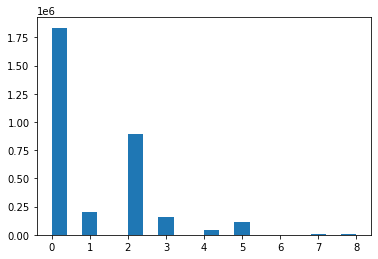

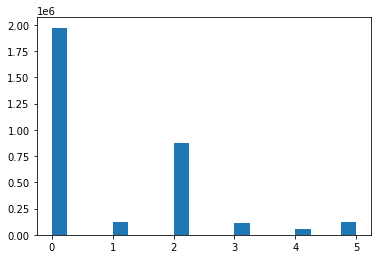

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [ ]:
seg_ref_im = np.transpose(seg_ref_list[-1].numpy(),(1,2,0)).astype(float)

# print(seg_ref_im.min())
# print(seg_ref_im.max())


seg_im = np.transpose(seg_list[-1].numpy(),(1,2,0)).astype(float)

print(after_list[0].max())
print(seg_im.shape)

print(seg_ref_im.dtype)
print(seg_im.dtype)

plt.imshow(seg_ref_im[:,:,0], vmin=0, vmax=8)
plt.show()

plt.imshow(seg_im[:,:,0], vmin=0, vmax=8)
plt.show()


plt.hist(seg_list[-2].numpy().flatten(),20)
plt.show()

plt.hist(seg_ref_list[-2].numpy().flatten(),20)
plt.show()

print(seg_im)